![alt text](http://kldavenport.com/wp-content/uploads/2018/02/mdp-chain.png "Title")
Figure 2 from the book. A generator of bounded random walks. This Markov process generated the data sequences in the example. All walks begin in state D. From states B, C, D, E, and F, the walk has a 50% chance of moving either to the right or to the left. If either edge state, A or G, is entered, then the walk terminates.

#### Setting up our environment

In [1]:
import math, sys, json, random 
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.style
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.externals import joblib # Still better than pickle in 2018?
# To protect from IPython kernel switching mistakes
from __future__ import division
%matplotlib inline

#### Utility Functions
We implement the TD Lambda algorithm below as `tdlEstimate` the image below is from chapter 6 of the Sutton textbook.
![alt text](http://kldavenport.com/wp-content/uploads/2018/02/td0-algo.png "Title")


In [2]:
# TD Lambda
def tdlEstimate(alpha, _lambda, state_sequence, values):
    """
    alphas: array of arbitrary values (e.g. 0.005, 0.01, 0.015)
    _lambda: chosen from an arbitrary array (e.g. 0.1, 1)
    state sequence: an array chosen from an arbitrary set of sequence simulations such as [3, 4, 5, 6] or \
    [3, 4, 3, 2, 3, 4, 3, 4, 5, 6] per the MDP figure 2 above.
    returns: """
    
    # Per figure 2, we have 7 possible states, with two of them being end states (A,G)
    
    eligibility = np.zeros(7)
    updates     = np.zeros(7)

    for t in range(0, len(state_sequence) - 1):
        current_state = state_sequence[t]
        next_state = state_sequence[t+1]

        eligibility[current_state] += 1.0

        td = alpha * (values[next_state] - values[current_state])

        updates += td * eligibility
        eligibility *= _lambda

    return updates

# Simulator to generate random walk sequences in our MDP defined in fig 2 above
states = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

def simulate():
    """returns: a sequence of states picked from a uniform random sample such as 
    [3, 2, 1, 0] or [3, 4, 3, 4, 3, 4, 5, 6]
    """
    states = [3] # Start in center at "D"
    while states[-1] not in [0, 6]:
        states.append(states[-1] +  (1 if random.choice([True, False]) else -1)) # go left or right randomly

    return states

In [3]:
# Setup data for plots

random.seed(101)
# pg.20 gives true probabilities for states B, C, D, E, F
# truth = np.arange(1, 6) / 6.0
truth = [1 / 6, 1 / 3, 1 / 2, 2 / 3, 5 / 6]

dtype = np.float

num_train_sets = 100
num_sequences   = 10 # or episodes

training_sets = [[simulate() for i in range(num_sequences)] for i in range(num_train_sets)]

### Figure 3 Page 20

In [4]:
# Figure 3
alphas  = np.array([0.005, 0.01, 0.015], dtype=dtype)
lambdas = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], dtype=dtype) # given in figure 3 caption

results = []

for _lambda in lambdas:
    for alpha in alphas:
        rmses = []
        for training_set in training_sets:
            # values initialized to zero and updates via tdlEstimate
            values = np.zeros(7, dtype=dtype)
            iterations = 0
            
            while True:
                iterations += 1
                before  = np.copy(values)
                updates = np.zeros(7, dtype=dtype)
                # The reward for reaching state "G" (element 7)
                values[6] = 1.0

                for sequence in training_set: 
                    updates += tdlEstimate(alpha, _lambda, sequence, values)

                values += updates
                diff = np.sum(np.absolute(before - values))

                if diff < .000001:
                    break

            estimate = np.array(values[1:-1], dtype=dtype)
            error = (truth - estimate)
            rms   = np.sqrt(np.average(np.power(error, 2)))
            rmses.append(rms)

        result = [_lambda, alpha, np.mean(rmses), np.std(rmses)]
        results.append(result)

# outputs
# joblib.dump(results, 'results.pkl') 

In [10]:
# results = joblib.load('results.pkl') 
data = pd.DataFrame(results)
data.columns = ["lambda", "alpha", "rms", "rmsstd"]
data.head()

,lambda,alpha,rms,rmsstd
0,0.0,0.00,0.235702,0.000000
1,0.0,0.05,0.175010,0.002556
2,0.0,0.10,0.131192,0.009537
3,0.0,0.15,0.103448,0.020459
4,0.0,0.20,0.091540,0.033838


In [6]:
data = data[data.groupby(['lambda'])['rms'].transform(min) == data['rms']].set_index(keys=['lambda'])
data.drop('alpha', 1, inplace=True,)
data.drop('rmsstd', 1,inplace=True,)

I repeatedly calculated the TD equation on a given set until the RMSE  between the weights (new values) and the ideal probabilities was less than my arbitrary threshold.  
The values and trend are very similar to the original but more tweaking to my environment assumptions might have improved the similarity. Given more time and intellect I’d like to do a random search of a space of hyper-parameters and see what most closely approximates the original. RMS error increases with non-linearity in relation to lambda. The initial curtailing isn’t the same as Sutton with lambda 0 performing the best out right.

If we choose to imitate figure 3 literally we get the below. I would prefer grid lines though, which is just a matter of using default seaborn aesthetics.

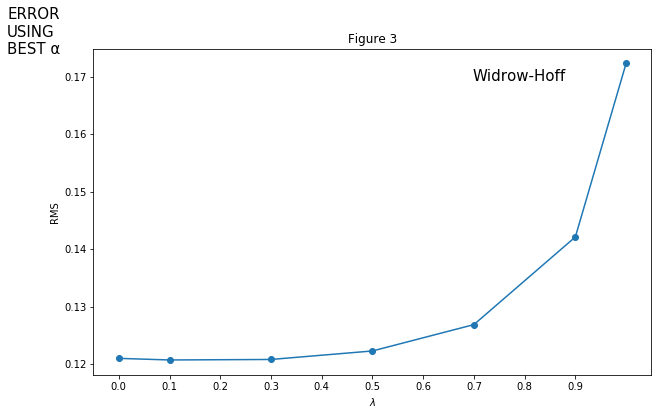

In [7]:
# sns.set_style("white")
plt.figure(num=None, figsize=(10, 6), dpi=72)
plt.margins(.05)
plt.xlabel(r"$\lambda$")
plt.ylabel("RMS")
plt.title("Figure 3")
plt.xticks([i * .1 for i in range(0, 10)])
plt.yticks([i * .01 for i in range(10, 19)])
plt.text(.79, .17, "Widrow-Hoff", ha="center", va="center", rotation=0,size=15)
plt.text(-.22, .174, "ERROR\nUSING\nBEST α",size=15)
plt.plot(data,marker='o');

### Figure 5 Page 21

In [12]:
%time 
alphas  = [0.05 * i for i in range(0,16)]
lambdas = [0.05 * i for i in range(0, 21)]

results = []

for _lambda in lambdas:
    for alpha in alphas:
        rms_vals = []
        for training_set in training_sets:

            values = np.array([0.5 for i in range(7)])

            for sequence in training_set:
                values[0] = 0.0
                values[6] = 1.0
                values += tdlEstimate(alpha, _lambda, sequence, values)

            estimate = np.array(values[1:-1])
            error = (truth - estimate)
            rms   = np.sqrt(np.average(np.power(error, 2)))

            rms_vals.append(rms)

        result = [_lambda, alpha, np.mean(rms_vals), np.std(rms_vals)]
        results.append(result)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


Here we reiterate that larger lambda values perform better via smaller learning rates. I believe this is due to the larger lambda values emphasizing weight on larger steps and the final output. 

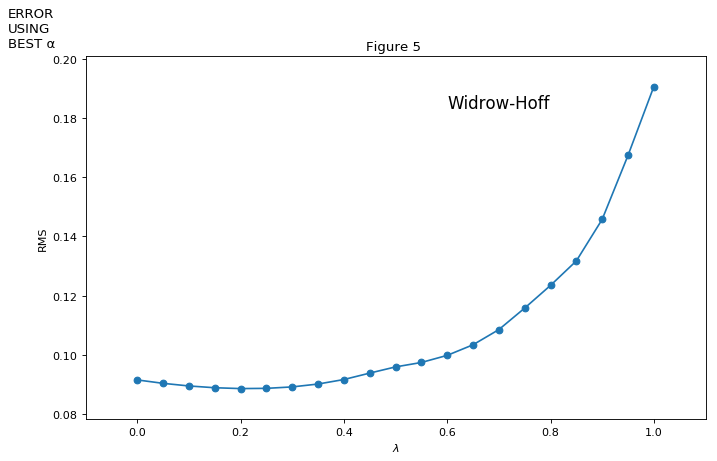

In [11]:
data = pd.DataFrame(results)

data.columns = ["lambda", "alpha", "rms", "rmsstd"]

data = data[data.groupby(['lambda'])['rms'].transform(min) == \
            data['rms']].set_index(keys=['lambda'])

data = data.drop('alpha', 1)
data = data.drop('rmsstd', 1)

plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.plot(data, marker='o') 
plt.margins(.10)
plt.xlabel(r"$\lambda$")
plt.ylabel("RMS")
plt.title("Figure 5 ")
plt.text(.7, .185, "Widrow-Hoff", ha="center", va="center", rotation=0,size=15)
plt.text(-.25,.204, "ERROR\nUSING\nBEST α",size=12)

In [14]:
from IPython.display import HTML

By the way here is a short simple video from Peter Norvig that provides good intuition on TD learning.

In [16]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/DZzffdHNqtQ" frameborder="0" allowfullscreen></iframe>')